In [1]:
%load_ext autoreload
%autoreload 2

# EEG models analysis

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np

## Display learning curves

In [8]:
def results_path(model_date):
    return os.path.join("./Results/Pre_Training/EEG", model_date)

def get_results_model(model_date, kfold):
    file_test_results = os.path.join(results_path(model_date), 'EEG_linear_result.txt')
    results = pd.read_csv(file_test_results, sep=', ')
    if kfold:
        i = results[results['train_loss']=='train_loss'].index
        results = results.drop(i)
        fold = [k//(i[0]) for k in range(len(results))]
        results["fold"] = fold
        results = results.astype(float)
    return results

#def load_

def get_mean_min_max_kfold(results):
    n_epochs = int(max(results['#']))
    mean_values = []
    min_values = []
    max_values = []
    for i in range(n_epochs+1):
        mean_values.append(results[results['#']==i].mean())
        min_values.append(results[results['#']==i].min())
        max_values.append(results[results['#']==i].max())
    return pd.DataFrame(mean_values), pd.DataFrame(min_values), pd.DataFrame(max_values)

def print_learning_curves(models, model_name, kfold=False):
    model_date = models[model_name]
    results = get_results_model(model_date=model_date, kfold=kfold)
    if kfold:
        mean_values, min_values, max_values = get_mean_min_max_kfold(results)
    # Create figure with 2 subplots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for col in ['train_loss', 'test_loss']:
        if kfold:
            plt.plot(mean_values[col], label=col+'_mean')
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=col)
    plt.ylabel('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curves for model {model_name}')
    plt.subplot(1, 2, 2)
    acc_columns = [col for col in results.columns if 'test_acc' in col]
    for col in acc_columns:
        if kfold:
            plt.plot(mean_values[col], label=col+'_mean')
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=col)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curves for model {model_name}')
    plt.show()
    return results

def compare_learning_curves(models, kfold=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    col="test_loss"
    for model_name, model_date in models.items():
        results = get_results_model(model_date=model_date, kfold=kfold)
        if kfold:
            mean_values, min_values, max_values = get_mean_min_max_kfold(results)
            plt.plot(mean_values[col], label=model_name)
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=model_name)
    plt.ylabel('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curve for {col}')

    plt.subplot(1, 2, 2)
    col = 'test_acc_all'
    for model_name, model_date in models.items():
        results = get_results_model(model_date=model_date, kfold=kfold)
        if kfold:
            mean_values, min_values, max_values = get_mean_min_max_kfold(results)
            plt.plot(mean_values[col], label=model_name)
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.2)
        else:
            plt.plot(results[col], label=model_name)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(f'Learning curve for {col}')
    plt.show()
    

/var/tmp/ipykernel_9980/1588638364.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ')
/var/tmp/ipykernel_9980/1588638364.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ')
/var/tmp/ipykernel_9980/1588638364.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ')
/

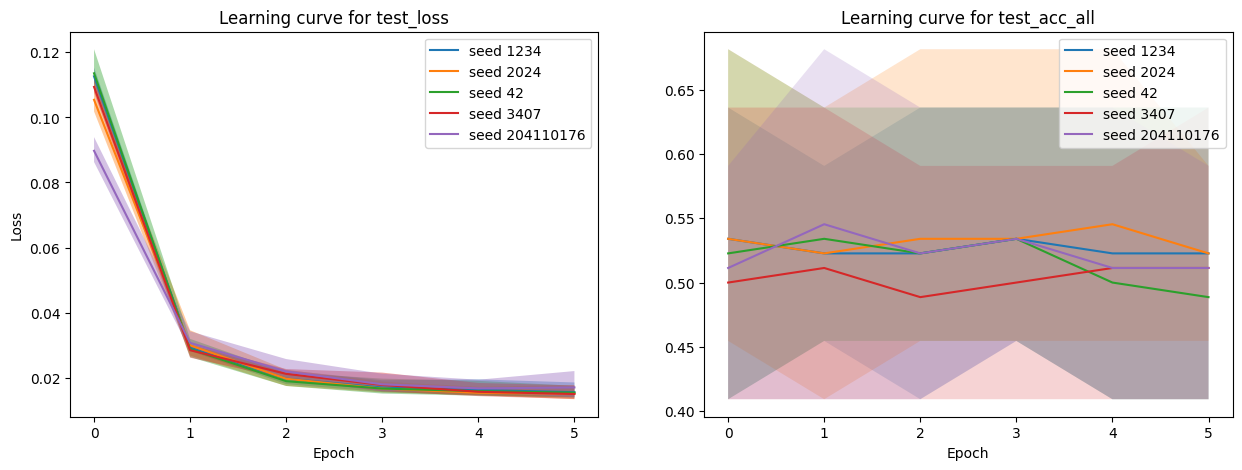

In [10]:
# Write reference of models to analyse with a name to identify them
models = {"500_epochs_2s_seed_1234":"2024-10-11_14-02",
          "500_epochs_2s_seed_17":"2024-10-11_19-29",
          "params_other_team":"2024-10-15_12-19",
          "newest_model_unbalanced":"2024-10-16_08-04"}

models = {"seed 1234":"2024-11-05_06-49",
          #"4fold split 1":"2024-11-04_19-18",
          #"4fold split 2":"2024-11-05_06-49",
          "seed 2024":"2024-11-04_20-03",
          "seed 42": "2024-11-04_20-37",
          "seed 3407": "2024-11-04_21-16",
          "seed 204110176": "2024-11-04_22-28",
          #"zheyun_params":"2024-11-05_15-16",
          }

#results = print_learning_curves(models, "zheyun_params", kfold=True)
#results = print_learning_curves(models, "seed 1234", kfold=True)
compare_learning_curves(models, kfold=True)

,#,train_loss,test_loss,train_acc_all,test_acc_all,test_acc_C,test_acc_A,test_acc_F,train_acc_C,train_acc_A,train_acc_F,fold
0,0.0,0.112159,0.115304,0.742424,0.636364,0.875000,0.555556,0.400000,0.857143,0.851852,0.444444,0.0
1,1.0,0.041279,0.029650,0.742424,0.590909,0.875000,0.555556,0.200000,0.809524,0.888889,0.444444,0.0
2,2.0,0.020611,0.022273,0.757576,0.636364,0.875000,0.555556,0.400000,0.857143,0.888889,0.444444,0.0
3,3.0,0.015968,0.019201,0.681818,0.636364,0.875000,0.555556,0.400000,0.809524,0.740741,0.444444,0.0
4,4.0,0.014818,0.019455,0.696970,0.636364,0.875000,0.555556,0.400000,0.809524,0.777778,0.444444,0.0
5,5.0,0.013697,0.018512,0.696970,0.636364,0.875000,0.555556,0.400000,0.809524,0.777778,0.444444,0.0
7,0.0,0.112394,0.110591,0.757576,0.590909,1.000000,0.555556,0.166667,0.863636,0.851852,0.470588,1.0
8,1.0,0.042414,0.028985,0.772727,0.545455,1.000000,0.555556,0.000000,0.863636,0.888889,0.470588,1.0
9,2.0,0.022971,0.018081,0.757576,0.545455,1.000000,0.555556,0.000000,0.863636,0.888889,0.411765,1.0
10,3.0,0.016556,0.016106,0.757576,0.590909,1.000000,0.555556,0.000000,0.863636,0.851852,0.470588,1.0


## Try fitting ML model to embeddings

/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cleaned up TensorBoard directory: summary
Current root path (path to EEG dataset): ./Dataset/EEG/EEG/
train: 70 sub = 18 F (4166, 4166) 29 A (7941, 7941) 23 C (6658, 6658)

test: 18 sub = 7 A (2087, 2087) 5 F (1239, 1239) 6 C (1678, 1678)

(18765, 4, 200) (0, 0) (5004, 4, 200)


2024-10-21 19:43:46,830 | INFO : 18765 samples will be used for training
2024-10-21 19:43:46,832 | INFO : Train Data Shape is #18765 samples, 4 channels, 200 time steps 
2024-10-21 19:43:46,832 | INFO : 5004 samples will be used for testing
2024-10-21 19:43:46,841 | INFO : Model:
Seires2Vec(
  (embed_layer): DisjoinEncoder(
    (temporal_CNN): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 8), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (spatial_CNN): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (rep_CNN): Sequential(
      (0): Conv1d(16, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
  )
  (embed_layer_f): Disjoi

Loaded model from ./Results/Pre_Training/EEG/2024-10-16_08-04/checkpoints/EEG_model_last.pth. Epoch: 26


/home/pauli/self-supervised-learning-eeg/models/Series2Vec/Series2Vec.py:44: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  x_f = torch.fft.fft(x).float()


NameError: name 'root_path' is not defined

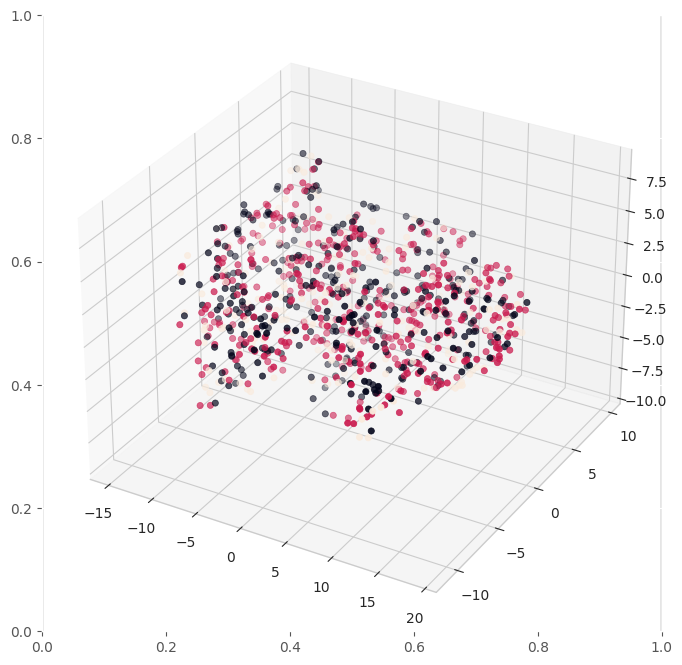

In [5]:
from visualize import load_config_from_json, visualize
from models.model_factory import Model_factory
from Dataset.dataloader import data_loader, dataset_class
from torch.utils.data import DataLoader
from torch import tensor
from Dataset.dataloader import dataset_class
from utils.utils import load_model
from models.Series2Vec.S2V_training import S2V_make_representation

problem = "EEG"
root_path = "./"
result_path = "Results/Pre_Training/EEG/2024-10-16_08-04"
config = load_config_from_json(root_path, result_path, problem)
Data = data_loader(config, is_analysis=True)
model = Model_factory(config, Data)

# --------------------------------- Load Data ---------------------------------
train_dataset = dataset_class(Data['train_data'], Data['train_label'], config)
test_dataset = dataset_class(Data['test_data'], Data['test_label'], config)

train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# --------------------------------- Load Model --------------------------------
SS_Encoder = load_model(model, model_path=config['model_dir'], optimizer=None)  # Loading the model
SS_Encoder.to(config['device'])
train_repr, train_labels = S2V_make_representation(SS_Encoder, train_loader)
test_repr, test_labels = S2V_make_representation(SS_Encoder, test_loader)

# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_labels,
          reducer_type='tsne', # 'tsne', 'umap''
          problem=problem, 
          n_components=3, # 2, 3
          n_points=1000
          )


In [6]:
from Dataset.dataloader import data_loader
from torch import tensor

In [7]:
import numpy as np
subjects = Data['train_subjects']
ids_group = [[sub.participant_id]*len(sub.epochs) for sub in subjects]

import itertools
ids_group = np.array(list(itertools.chain.from_iterable(ids_group)))
ids_group.shape


KeyError: 'train_subjects'

In [10]:
from Dataset.EEG.EEG.EEG_Loader import load_participants

subjects = load_participants("Dataset/EEG/EEG/participants.tsv")
subjects = subjects.set_index('participant_id')
subjects.to_dict()

train_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['train_ids']]))
test_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['test_ids']]))

train_age = tensor(np.array([subjects['Age'][ID] for ID in Data['train_ids']]))
test_age = tensor(np.array([subjects['Age'][ID] for ID in Data['test_ids']]))

In [9]:
def gender_encoding(gender_str):
    if gender_str == 'F':
        return 0
    else:
        return 1

NameError: name 'root_path' is not defined

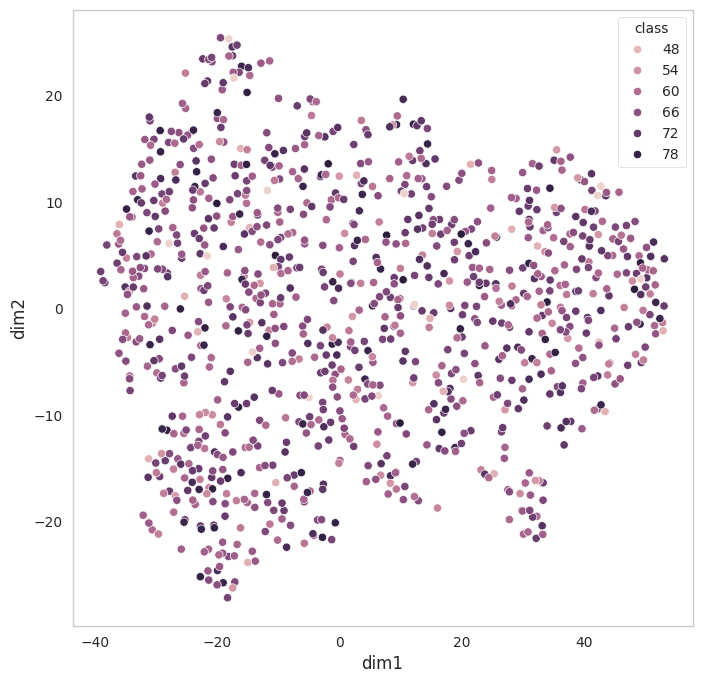

In [11]:
# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_age,
          reducer_type='tsne', # 'tsne', 'umap''
          problem=problem, 
          n_components=2, # 2, 3
          n_points=1000
          )

In [ ]:
# Create SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create pipeline
clf = SVC(C=1, gamma=2)
clf.fit(train_repr[:10].cpu(), train_age[:10].cpu())
print("Training done")
y_pred = clf.predict(test_repr.cpu())

print(classification_report(test_age, y_pred))